# 多 Agent 协作自动修复 K8s 故障
1. 管理员 Agent
2. 自动修复 Agent
3. 寻求人类帮助 Agent 
4. 网络搜索 Agent
5. 执行代码 Agent
6. GetK8sYAML Agent

In [30]:
! capture --no-stderr
! pip3 install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

zsh:1: command not found: capture


In [31]:
import getpass
import os

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide you {var}: ")
        
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

import time
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonAstREPLTool

tavily_tool = TavilySearchResults(max_results=5)

python_repl_tool = PythonAstREPLTool()

# 定义消息 Agent 结点
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return  {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)],
    }

In [32]:
from typing import Sequence
# 定义 supervisor Agent 和调度逻辑
# 管理员 Agent，负责决定下一个由哪个 Agent 来执行任务

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal
import operator
from  typing_extensions import TypedDict

from  langchain_core.messages import BaseMessage

# 定义成员 Agent 和系统提示语，告诉 supervisor 要负责调度多个 Agent
members = ["Researcher", "Coder", "HumanHelp", "GetK8sYAML"]
system_prompt = (
    f"""You are a supervisor tasked with managing a conversation between the following workers: {members}. Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. When finished, respond with FINISH."""
)
options = ["FINISH"] + members

# 定义 supervisor 的响应类，选择下一个执行的 Agent
class routeResponse(BaseModel):
    next: Literal[*options]
    
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            f"""Given the conversation above, who should act next? Or should we FINISH Select one of: {options}"""
        )
    ]
).partial(options=str(options), members=", ".join(members))

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str

llm = ChatOpenAI(model="gtp-4o", base_url="https://vip.apiyi.com/v1")

def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [33]:
from kubernetes import client, config, watch

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()

In [34]:
# 定义 K8s get yaml 工具
from langchain_core.tools import tool
import yaml

@tool
def get_k8s_yaml(deployment_name, namespace):
    """获取 K8s 部署的 YAML"""
    deployment = k8s_apps_v1.read_namespaced_deployment(name=deployment_name, namespace=namespace)
    deployment_dict = deployment.to_dict()
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)
    return yaml.dump(deployment_dict)

In [35]:
# 定义 K8s 自动修复工具
from langchain_core.tools import tool
from openai import OpenAI

@tool
def auto_fix_k8s(deployment_name, namespace, deployment_yaml, event: str):
    """自动修复 K8s 部署"""
    # 如果为空返回错误
    if not deployment_yaml:
        return "Deployment not found"
    openAIClient = OpenAI(base_url="https://vip.apiyi.com/v1")
    response = openAIClient.chat.completions.create(
        model="gpt-4o",
        response_format={"type":"json_object"},
        message = [
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
            K8s 抛出的错误信息是: {event}
            工作负载的 YAML 是: 
            {deployment_yaml}
            你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
            """
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"Failed to apply patch: {str(e)}")
        return f"Failed to apply patch: {str(e)}"
    return f"Successfully fix the deployment"

In [36]:
import requests
import json

@tool
def human_help(event_message: str):
    """无法修复问题时寻求人工帮助"""
    url = "https://open.feishu.cn/open-apis/bot/v2/hook/7b7b7b7b-7b7b-7b7b-7b7b-7b7b7b7b7b7b"
    headers = { "Content-Type": "application/json" }
    data = {
        "msg_type": "text",
        "content": {
            "text": event_message
        }
    }
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return "Success sent message to human help, FINISH"

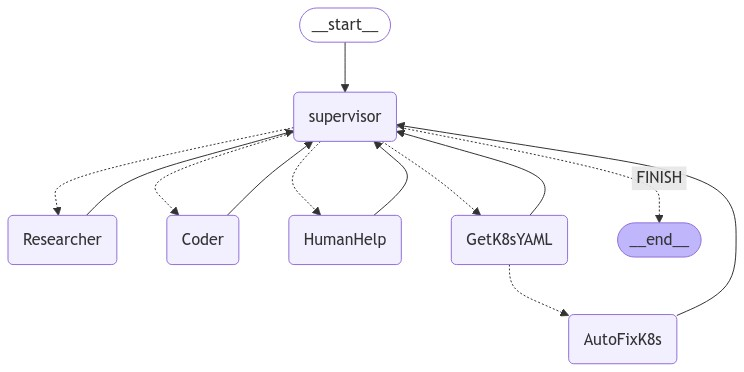

In [37]:
# 定义工作流和 Graph（有向有环图）
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research Agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# auto fix agent
auto_fix_agent = create_react_agent(llm, tools=[auto_fix_k8s])
auto_fix_node = functools.partial(agent_node, agent=auto_fix_agent, name="AutoFixK8s")

# human help agent
human_help_agent = create_react_agent(llm, tools=[human_help])
human_help_node = functools.partial(agent_node, agent=human_help_agent, name="HumanHelp")

# get k8s yaml agent
get_k8s_yaml_agent = create_react_agent(llm, tools=[get_k8s_yaml])
get_k8s_yaml_node = functools.partial(agent_node, agent=get_k8s_yaml_agent, name="GetK8sYAML")

# 创建 Graph 并添加结点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("AutoFixK8s", auto_fix_node)
workflow.add_node("HumanHelp", human_help_node)
workflow.add_node("GetK8sYAML", get_k8s_yaml_node)
workflow.add_node("supervisor", supervisor_agent)

for member in members:
    workflow.add_edge(members, "supervisor")
    
workflow.add_conditional_edges("GetK8sYAML", lambda x: x["next"] == "AutoFixK8s", {"AutoFixK8s": "AutoFixK8s"})
workflow.add_edge("AutoFixK8s", "supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [39]:
# 捕获和处理 K8s 事件
from kubernetes import client

core_v1 = client.CoreV1Api()
w = watch.Watch()

def run_stream(message: str):
    for s in graph.stream(
            {
                "messages": [HumanMessage(content=message)],
            }
    ):
        if "__end__" not in s:
            print(s)
            print("----")
    
try:
    for event in w.stream(core_v1.list_namespaced_event, namespace="default", _request_timeout=None):
        event_type = event["type"]
        event_object = event["object"]
        if event_object.type == "Warning":
            involved_object = event_object.involved_object
            pod_name = involved_object.name
            reason = event_object.reason
            message = event_object.message
            
            print(f"Warning Event: {event_type} {pod_name} {reason} {message}")
            
            try:
                pod = core_v1.read_namespaced_pod(name=pod_name, namespace="default")
                deployment_name = pod.metadata.labels.get("app", "unknown")
            except client.exceptions.ApiException as e:
                print(f"Failed to get pod: {str(e)}")
                continue
                
            try:
                run_stream(f"deployment: {deployment_name}, namespace: default, event: {reason} - {message}")
                time.sleep(10)
            except Exception as e:
                print(e)
                continue
        else:
            print(f"Ignore non-warning event: {event_object.type} {event_object.reason} - {event_object.message}")
            
finally:
    w.stop()

Ignore non-warning event: Normal Scheduled - Successfully assigned default/nginx-796f4fb6cb-lztvv to ip-192-168-1-169.us-east-2.compute.internal
Ignore non-warning event: Normal Pulling - Pulling image "nginx:latess"
Warning Event: ADDED nginx-796f4fb6cb-lztvv Failed Failed to pull image "nginx:latess": rpc error: code = NotFound desc = failed to pull and unpack image "docker.io/library/nginx:latess": failed to resolve reference "docker.io/library/nginx:latess": docker.io/library/nginx:latess: not found
Error code: 503 - {'error': {'message': '当前分组 default 下对于模型 gtp-4o 计费模式 [按量计费,按次计费] 无可用渠道 (request id: 2024110714242816805679817407850)', 'type': 'shell_api_error'}}
Warning Event: ADDED nginx-796f4fb6cb-lztvv Failed Error: ErrImagePull
Error code: 503 - {'error': {'message': '当前分组 default 下对于模型 gtp-4o 计费模式 [按量计费,按次计费] 无可用渠道 (request id: 2024110714242999065224461725944)', 'type': 'shell_api_error'}}
Ignore non-warning event: Normal BackOff - Back-off pulling image "nginx:latess"
Warning

KeyboardInterrupt: 